### CGAN  on MNIST

DCGAN is a Generative Adversarial Network (GAN) using CNN.

1. The discriminator learns to discriminate real from fake images.
2. The generator tries to fool the discriminator by generating fake images.
3. The generator + discriminator form an adversarial network.
4. DCGAN trains the discriminator and adversarial networks alternately.

During training, not only the discriminator learns to distinguish real from
fake images, it also coaches the generator part of the Adversarial network on how
to improve its ability to generate fake images.

In [1]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
import os

#### Buiding a Generator Model

Build a model using layers of BatchNorm-ReLU-Conv2DTranpose to generate fake images

In [2]:
def build_generator(noise_inputs, label_inputs, image_size=28):
            
    #Concatenate both noise and labels
    x1 = tf.keras.layers.concatenate([noise_inputs, label_inputs], axis=1)
    
    #Increase dimensions and resize to 3D to feed it to Conv2DTranspose layer
    x2 = tf.keras.layers.Dense(7 * 7 * 128)(x1)
    x3 = tf.keras.layers.Reshape((7, 7,128))(x2)
    
    #Use ConvTranspose
    x4 = tf.keras.layers.BatchNormalization()(x3)
    x5 = tf.keras.layers.Activation('relu')(x4)
    x6 = tf.keras.layers.Conv2DTranspose(128, kernel_size=[5,5], strides=2, padding='same')(x5)
    
    x7 = tf.keras.layers.BatchNormalization()(x6)
    x8 = tf.keras.layers.Activation('relu')(x7)
    x9 = tf.keras.layers.Conv2DTranspose(64, kernel_size=[5,5], strides=2, padding='same')(x8)
    
    x10 = tf.keras.layers.BatchNormalization()(x9)
    x11 = tf.keras.layers.Activation('relu')(x10)
    x12 = tf.keras.layers.Conv2DTranspose(32, kernel_size=[5,5], strides=1, padding='same')(x11)
    
    x13 = tf.keras.layers.BatchNormalization()(x12)
    x14 = tf.keras.layers.Activation('relu')(x13)
    x15 = tf.keras.layers.Conv2DTranspose(1, kernel_size=[5,5], strides=1, padding='same')(x14)
    
    #Output layer for Generator
    x = tf.keras.layers.Activation('sigmoid')(x15)
    
    generator = tf.keras.models.Model([noise_inputs, label_inputs], x, name='generator')
    
    return generator

#### Building a Discriminator

In [3]:
def build_discriminator(image_inputs, label_inputs, image_size=28):
    
    #Network parameters
    filter_size = 5
    num_filters = [32, 64, 128, 256]
    stride_size = [2, 2, 2, 1]
    
    #Build the network
    x = image_inputs
    
    #Make label_inputs of same size as image_inputs for concatenation
    y = tf.keras.layers.Dense(28*28)(label_inputs)
    y = tf.keras.layers.Reshape((28,28,1))(y)
    
    x = tf.keras.layers.concatenate([x, y])
    
    
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Conv2D(32, kernel_size=[5,5], strides=2, padding='same')(x)
    
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=[5,5], strides=2, padding='same')(x)
    
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Conv2D(128, kernel_size=[5,5], strides=2, padding='same')(x)
    
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Conv2D(256, kernel_size=[5,5], strides=1, padding='same')(x)
    
    #Flatten the output and build an output layer
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    #Build Model
    discriminator = tf.keras.models.Model([image_inputs, label_inputs],
                                          x, name='discriminator')
    
    return discriminator

#### Building Models for Training

In [4]:
def build_models():
    
    noise_size = 100
    lr = 2e-4
    decay = 6e-8
    
    #Build input layers
    noise_inputs = tf.keras.layers.Input(shape=(noise_size,)) #to feed the randon numbers
    label_inputs = tf.keras.layers.Input(shape=(10,)) #feed label input

    image_inputs = tf.keras.layers.Input(shape=(28, 28, 1,)) #for Discriminator's image input
    
    #Build Base Discriminator model    
    base_discriminator = build_discriminator(image_inputs, label_inputs)
    
    #Define discriminator, optimizer and compile model
    discriminator = tf.keras.models.Model(inputs=base_discriminator.inputs, 
                                          outputs=base_discriminator.outputs)
    optimizer = tf.keras.optimizers.RMSprop(lr=lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    
    #Build Generator model
    generator = build_generator(noise_inputs, label_inputs)
    
    #Build Frozen Discriminator
    frozen_discriminator = tf.keras.models.Model(inputs=base_discriminator.inputs, 
                                          outputs=base_discriminator.outputs)
    #Freeze the weights of discriminator during adversarial training
    frozen_discriminator.trainable = False

    #Build Adversarial model
    optimizer = tf.keras.optimizers.RMSprop(lr=lr * 0.5, decay=decay * 0.5)
        
    #Adversarial = generator + discriminator
    adversarial = tf.keras.models.Model([noise_inputs, label_inputs],
                                        frozen_discriminator([generator([noise_inputs, label_inputs]), label_inputs]))
    
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])    
    
    return generator, discriminator, adversarial

#### Training Discriminator and Adversarial Models

In [5]:
np.eye(10)[np.random.choice(10, 16)]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [6]:
def train_gan(generator, discriminator, adversarial, noise_size=100):
    
    #Training parameters
    batch_size = 64
    train_steps = 10000
    image_size = 28
    num_labels = 10
    
    # load MNIST dataset
    (train_x, train_y), (_, _) = tf.keras.datasets.mnist.load_data()

    #Make it 3D dataset - 28x28 to 28x28x1
    train_x = np.reshape(train_x, [-1, image_size, image_size, 1])

    #Standardize data : 0 to 1
    train_x = train_x.astype('float32') / 255
    
    #Convert labels to one-hot encoding
    train_y = tf.keras.utils.to_categorical(train_y)
    
    #Input for testing generator at different intervals, we will generate 16 images
    test_noise_input = np.random.uniform(-1.0,1.0, size=[16, noise_size])
    test_fake_labels = np.eye(num_labels)[np.random.choice(num_labels, 16)]
    
    #Start training
    for i in range(train_steps):
        
        #Train DISCRIMATOR
        
        #1. Get fake images from Generator
        noise_input = np.random.uniform(-1.0,1.0, size=[batch_size, noise_size])
        fake_labels = np.eye(num_labels)[np.random.choice(num_labels, batch_size)]
        fake_images = generator.predict([noise_input, fake_labels]) #64 fake pics
        
        
        #2. Get real images and labels from training set
        img_indexes = np.random.randint(0, train_x.shape[0], size=batch_size)
        real_images = train_x[img_indexes]
        real_labels = train_y[img_indexes]
        
        #3. Prepare input for training Discriminator
        X_images = np.concatenate((real_images, fake_images)) #128,28,28,1
        X_labels = np.concatenate((real_labels, fake_labels)) #128, 10 - MNIST LABELS
        
        #4. Labels for training
        y_real = np.ones((batch_size, 1))
        y_fake = np.zeros((batch_size, 1))
        y = np.concatenate((y_real, y_fake)) #128, 1 - this will be used for loss calculation
        
        #5. Train Discriminator
        d_loss, d_acc = discriminator.train_on_batch([X_images, X_labels], y)
        
        
        #Train ADVERSARIAL Network
        
        #1. Prepare input - create a new batch of noise
        X_noise = np.random.uniform(-1.0,1.0, size=[batch_size, noise_size]) #64, 100
        X_fake_labels = np.eye(num_labels)[np.random.choice(num_labels, batch_size)] #64, 10
        
        #2. Prepare labels - training Adversarial network to lie :) - All 1s
        y = np.ones((batch_size, 1)) #64, 1
        
        #3. Train - Pls note Discrimator is not getting trained here
        a_loss, a_acc = adversarial.train_on_batch([X_noise, X_fake_labels], y)
        
        if i % 100 == 0:
            #Print loss and Accuracy for both networks
            print("%s [Discriminator loss: %f, acc: %f, Adversarial loss: %f, acc: %f]" % (i, d_loss, d_acc, a_loss, a_acc) )
        
        #Save generated images to see how well Generator is doing
        if (i+1) % 500 == 0:
            
            #Generate 16 images
            fake_images = generator.predict([test_noise_input, test_fake_labels])
            
            #Display images
            plot_images(fake_images, i+1)
            
    #Save Generator model
    generator.save('mnist_generator_cgan.h5')   

#### Save generator images

In [7]:
def plot_images(fake_images, step):
    
    plt.figure(figsize=(2.2, 2.2))
    num_images = fake_images.shape[0]
    
    image_size = fake_images.shape[1]
    rows = int(math.sqrt(fake_images.shape[0]))
    
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(fake_images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.show()    

### Start GAN Training

In [8]:
G, D, A = build_models()

In [9]:
G.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 110)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 6272)         696192      concatenate_1[0][0]      

In [10]:
D.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 784)          8624        input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 28, 28, 1)    0           dense[0][0]                      
_______________________________________________________________________________________

In [11]:
A.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
generator (Functional)          (None, 28, 28, 1)    1364225     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 1)            1090001     generator[0][0]       

11493376/11490434 [==============================] - 0s 0us/step
0 [Discriminator loss: 0.692654, acc: 0.468750, Adversarial loss: 1.134970, acc: 0.000000]
100 [Discriminator loss: 0.000040, acc: 1.000000, Adversarial loss: 0.000308, acc: 1.000000]
200 [Discriminator loss: 0.000004, acc: 1.000000, Adversarial loss: 0.000537, acc: 1.000000]
300 [Discriminator loss: 0.000010, acc: 1.000000, Adversarial loss: 0.000630, acc: 1.000000]
400 [Discriminator loss: 0.144922, acc: 0.968750, Adversarial loss: 0.040231, acc: 1.000000]


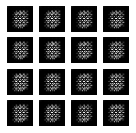

500 [Discriminator loss: 0.315014, acc: 0.851562, Adversarial loss: 7.320046, acc: 0.000000]
600 [Discriminator loss: 0.021727, acc: 1.000000, Adversarial loss: 0.097023, acc: 1.000000]
700 [Discriminator loss: 0.238725, acc: 0.929688, Adversarial loss: 3.289211, acc: 0.000000]
800 [Discriminator loss: 0.455642, acc: 0.781250, Adversarial loss: 1.743438, acc: 0.093750]
900 [Discriminator loss: 0.556743, acc: 0.695312, Adversarial loss: 0.749406, acc: 0.500000]


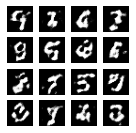

1000 [Discriminator loss: 0.535878, acc: 0.757812, Adversarial loss: 1.573929, acc: 0.015625]
1100 [Discriminator loss: 0.521682, acc: 0.750000, Adversarial loss: 1.545852, acc: 0.109375]
1200 [Discriminator loss: 0.362853, acc: 0.890625, Adversarial loss: 1.822289, acc: 0.046875]
1300 [Discriminator loss: 0.486764, acc: 0.750000, Adversarial loss: 1.344646, acc: 0.125000]
1400 [Discriminator loss: 0.537515, acc: 0.742188, Adversarial loss: 1.120870, acc: 0.312500]


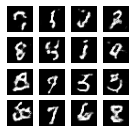

1500 [Discriminator loss: 0.522231, acc: 0.750000, Adversarial loss: 0.865493, acc: 0.437500]
1600 [Discriminator loss: 0.481333, acc: 0.796875, Adversarial loss: 1.079925, acc: 0.281250]
1700 [Discriminator loss: 0.616432, acc: 0.671875, Adversarial loss: 0.973716, acc: 0.484375]
1800 [Discriminator loss: 0.503712, acc: 0.742188, Adversarial loss: 1.465530, acc: 0.140625]
1900 [Discriminator loss: 0.514127, acc: 0.718750, Adversarial loss: 1.246421, acc: 0.171875]


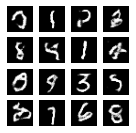

2000 [Discriminator loss: 0.509094, acc: 0.734375, Adversarial loss: 1.132547, acc: 0.265625]
2100 [Discriminator loss: 0.571918, acc: 0.687500, Adversarial loss: 1.037121, acc: 0.250000]
2200 [Discriminator loss: 0.606481, acc: 0.718750, Adversarial loss: 0.966439, acc: 0.296875]
2300 [Discriminator loss: 0.598472, acc: 0.656250, Adversarial loss: 1.271941, acc: 0.203125]
2400 [Discriminator loss: 0.624861, acc: 0.671875, Adversarial loss: 1.201050, acc: 0.109375]


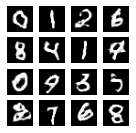

2500 [Discriminator loss: 0.564714, acc: 0.687500, Adversarial loss: 1.102136, acc: 0.171875]
2600 [Discriminator loss: 0.578782, acc: 0.695312, Adversarial loss: 1.023485, acc: 0.218750]
2700 [Discriminator loss: 0.679965, acc: 0.593750, Adversarial loss: 1.549592, acc: 0.000000]
2800 [Discriminator loss: 0.720644, acc: 0.609375, Adversarial loss: 0.798396, acc: 0.359375]
2900 [Discriminator loss: 0.663244, acc: 0.679688, Adversarial loss: 0.873848, acc: 0.437500]


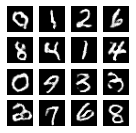

3000 [Discriminator loss: 0.582001, acc: 0.664062, Adversarial loss: 0.796033, acc: 0.468750]
3100 [Discriminator loss: 0.682616, acc: 0.632812, Adversarial loss: 0.884068, acc: 0.375000]
3200 [Discriminator loss: 0.658556, acc: 0.617188, Adversarial loss: 0.865965, acc: 0.390625]
3300 [Discriminator loss: 0.660624, acc: 0.562500, Adversarial loss: 0.983233, acc: 0.218750]
3400 [Discriminator loss: 0.619426, acc: 0.664062, Adversarial loss: 0.970785, acc: 0.312500]


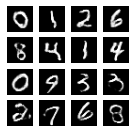

3500 [Discriminator loss: 0.645935, acc: 0.640625, Adversarial loss: 0.839032, acc: 0.390625]
3600 [Discriminator loss: 0.641469, acc: 0.656250, Adversarial loss: 0.961204, acc: 0.328125]
3700 [Discriminator loss: 0.631890, acc: 0.601562, Adversarial loss: 0.824090, acc: 0.421875]
3800 [Discriminator loss: 0.659215, acc: 0.609375, Adversarial loss: 1.014419, acc: 0.203125]
3900 [Discriminator loss: 0.600864, acc: 0.679688, Adversarial loss: 0.847973, acc: 0.359375]


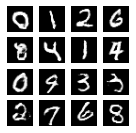

4000 [Discriminator loss: 0.665751, acc: 0.578125, Adversarial loss: 1.096412, acc: 0.171875]
4100 [Discriminator loss: 0.634349, acc: 0.640625, Adversarial loss: 0.836569, acc: 0.359375]
4200 [Discriminator loss: 0.660217, acc: 0.609375, Adversarial loss: 0.933539, acc: 0.312500]
4300 [Discriminator loss: 0.618822, acc: 0.601562, Adversarial loss: 1.025536, acc: 0.187500]
4400 [Discriminator loss: 0.671623, acc: 0.617188, Adversarial loss: 0.742815, acc: 0.500000]


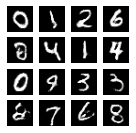

4500 [Discriminator loss: 0.579479, acc: 0.687500, Adversarial loss: 0.864833, acc: 0.359375]
4600 [Discriminator loss: 0.647333, acc: 0.601562, Adversarial loss: 0.780107, acc: 0.406250]
4700 [Discriminator loss: 0.664377, acc: 0.585938, Adversarial loss: 0.670425, acc: 0.640625]
4800 [Discriminator loss: 0.600848, acc: 0.632812, Adversarial loss: 1.064454, acc: 0.187500]
4900 [Discriminator loss: 0.637581, acc: 0.671875, Adversarial loss: 0.763271, acc: 0.500000]


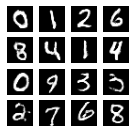

5000 [Discriminator loss: 0.677502, acc: 0.570312, Adversarial loss: 0.818610, acc: 0.406250]
5100 [Discriminator loss: 0.622954, acc: 0.648438, Adversarial loss: 0.894451, acc: 0.281250]
5200 [Discriminator loss: 0.653251, acc: 0.617188, Adversarial loss: 0.742494, acc: 0.437500]
5300 [Discriminator loss: 0.613346, acc: 0.656250, Adversarial loss: 0.997904, acc: 0.234375]
5400 [Discriminator loss: 0.662631, acc: 0.601562, Adversarial loss: 0.837327, acc: 0.390625]


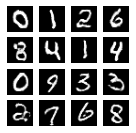

5500 [Discriminator loss: 0.616456, acc: 0.664062, Adversarial loss: 1.134232, acc: 0.156250]
5600 [Discriminator loss: 0.638061, acc: 0.617188, Adversarial loss: 0.719622, acc: 0.437500]
5700 [Discriminator loss: 0.625888, acc: 0.656250, Adversarial loss: 0.737504, acc: 0.515625]
5800 [Discriminator loss: 0.655800, acc: 0.578125, Adversarial loss: 0.988923, acc: 0.312500]
5900 [Discriminator loss: 0.652365, acc: 0.648438, Adversarial loss: 0.875756, acc: 0.281250]


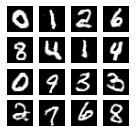

6000 [Discriminator loss: 0.669588, acc: 0.601562, Adversarial loss: 0.803026, acc: 0.406250]
6100 [Discriminator loss: 0.649750, acc: 0.617188, Adversarial loss: 0.801919, acc: 0.406250]
6200 [Discriminator loss: 0.653083, acc: 0.648438, Adversarial loss: 0.818396, acc: 0.421875]
6300 [Discriminator loss: 0.621424, acc: 0.656250, Adversarial loss: 0.795001, acc: 0.437500]
6400 [Discriminator loss: 0.641079, acc: 0.609375, Adversarial loss: 0.766141, acc: 0.375000]


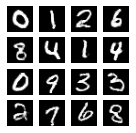

6500 [Discriminator loss: 0.667669, acc: 0.593750, Adversarial loss: 0.806331, acc: 0.359375]
6600 [Discriminator loss: 0.630189, acc: 0.648438, Adversarial loss: 0.831177, acc: 0.375000]
6700 [Discriminator loss: 0.641146, acc: 0.617188, Adversarial loss: 1.087899, acc: 0.203125]
6800 [Discriminator loss: 0.608937, acc: 0.664062, Adversarial loss: 0.844581, acc: 0.406250]
6900 [Discriminator loss: 0.662223, acc: 0.617188, Adversarial loss: 0.912447, acc: 0.218750]


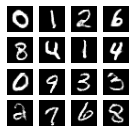

7000 [Discriminator loss: 0.624278, acc: 0.664062, Adversarial loss: 0.985435, acc: 0.203125]
7100 [Discriminator loss: 0.636160, acc: 0.585938, Adversarial loss: 0.970606, acc: 0.203125]
7200 [Discriminator loss: 0.621284, acc: 0.640625, Adversarial loss: 0.858378, acc: 0.359375]
7300 [Discriminator loss: 0.660687, acc: 0.601562, Adversarial loss: 0.786150, acc: 0.375000]
7400 [Discriminator loss: 0.604090, acc: 0.671875, Adversarial loss: 0.817557, acc: 0.390625]


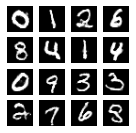

7500 [Discriminator loss: 0.690388, acc: 0.554688, Adversarial loss: 0.888660, acc: 0.281250]
7600 [Discriminator loss: 0.649913, acc: 0.632812, Adversarial loss: 0.819139, acc: 0.359375]
7700 [Discriminator loss: 0.642183, acc: 0.617188, Adversarial loss: 0.818648, acc: 0.359375]
7800 [Discriminator loss: 0.626305, acc: 0.632812, Adversarial loss: 0.837146, acc: 0.375000]
7900 [Discriminator loss: 0.655445, acc: 0.632812, Adversarial loss: 0.800202, acc: 0.421875]


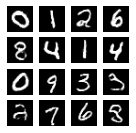

8000 [Discriminator loss: 0.626809, acc: 0.632812, Adversarial loss: 0.947997, acc: 0.312500]
8100 [Discriminator loss: 0.622517, acc: 0.718750, Adversarial loss: 0.868380, acc: 0.359375]
8200 [Discriminator loss: 0.628160, acc: 0.632812, Adversarial loss: 0.991028, acc: 0.250000]
8300 [Discriminator loss: 0.660997, acc: 0.632812, Adversarial loss: 0.966728, acc: 0.218750]
8400 [Discriminator loss: 0.654527, acc: 0.625000, Adversarial loss: 0.728065, acc: 0.484375]


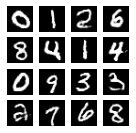

8500 [Discriminator loss: 0.636774, acc: 0.632812, Adversarial loss: 0.809492, acc: 0.500000]
8600 [Discriminator loss: 0.640740, acc: 0.664062, Adversarial loss: 0.834298, acc: 0.296875]
8700 [Discriminator loss: 0.603728, acc: 0.671875, Adversarial loss: 0.821332, acc: 0.343750]
8800 [Discriminator loss: 0.657587, acc: 0.601562, Adversarial loss: 0.717264, acc: 0.515625]
8900 [Discriminator loss: 0.660179, acc: 0.578125, Adversarial loss: 0.642417, acc: 0.593750]


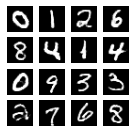

9000 [Discriminator loss: 0.674914, acc: 0.609375, Adversarial loss: 1.083416, acc: 0.171875]
9100 [Discriminator loss: 0.626665, acc: 0.679688, Adversarial loss: 0.898696, acc: 0.250000]
9200 [Discriminator loss: 0.673461, acc: 0.546875, Adversarial loss: 0.988034, acc: 0.187500]
9300 [Discriminator loss: 0.626512, acc: 0.695312, Adversarial loss: 0.751538, acc: 0.546875]
9400 [Discriminator loss: 0.645185, acc: 0.601562, Adversarial loss: 0.931726, acc: 0.218750]


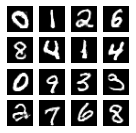

9500 [Discriminator loss: 0.618308, acc: 0.632812, Adversarial loss: 0.823958, acc: 0.375000]
9600 [Discriminator loss: 0.654863, acc: 0.593750, Adversarial loss: 0.822417, acc: 0.343750]
9700 [Discriminator loss: 0.594730, acc: 0.703125, Adversarial loss: 0.911327, acc: 0.250000]
9800 [Discriminator loss: 0.629690, acc: 0.656250, Adversarial loss: 1.008601, acc: 0.187500]
9900 [Discriminator loss: 0.667973, acc: 0.609375, Adversarial loss: 1.036204, acc: 0.187500]


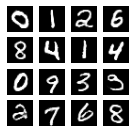

In [12]:
train_gan(G, D, A)

In [13]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [20]:
#Copy trained generator to current directory
!cp '/gdrive/My Drive/AIML/GAN/Notebooks/mnist_generator_cgan.h5' ./mnist_generator_cgan.h5

In [21]:
#Make sure h5 model file is available in current directory
!ls -l

total 5388
-rw-r--r-- 1 root root 5510096 Oct 11 10:51 mnist_generator_cgan.h5
drwxr-xr-x 1 root root    4096 Oct  5 16:31 sample_data


In [23]:
#Load Pre-trained model
generator = tf.keras.models.load_model('./mnist_generator_cgan.h5')

In [24]:
def test_generator(generator, label):
    
    test_noise_input = np.random.uniform(-1.0,1.0, size=[16, 100])
    test_fake_labels = np.eye(10)[np.repeat(label, 16)]
    fake_images = generator.predict([test_noise_input, test_fake_labels])
    plot_images(fake_images, 0)

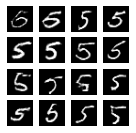

In [25]:
test_generator(generator, 5)

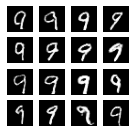

In [27]:
test_generator(generator, 9)

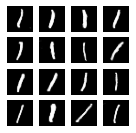

In [28]:
test_generator(generator, 1)